In [1]:
import xarray as xr
from obspy import UTCDateTime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from obspy.core import Trace
import seaborn as sns

In [2]:
#code to pull historic buoy data using the ERDDAP url (NOAA CoastWatch)
#need to know the station number and the start and end time
#whatever columns the buoy does not have, it will put NaN instead
#what each of the column variables means: https://www.ndbc.noaa.gov/faq/measdes.shtml

#forks washington
station = "46041"
start = "2025-12-05T00:00:00Z"
end   = "2025-12-11T00:00:00Z"

#santa barbara
#station = "46053"
#start = "2025-12-21T00:00:00Z"
#end   = "2025-12-27T00:00:00Z"

url = (
    "https://coastwatch.pfeg.noaa.gov/erddap/tabledap/"
    "cwwcNDBCMet.csv?"
    "station,longitude,latitude,time,"
    "wd,wspd,gst,wvht,dpd,apd,mwd,bar,"
    "atmp,wtmp,dewp,vis,ptdy,tide,wspu,wspv"
    f"&station=%22{station}%22"
    f"&time%3E={start}&time%3C={end}"
)

#to download the csv and look at it in excel, print the url below
#print(url)

# skip first row (units) and parse time
data = pd.read_csv(url, skiprows=[1], parse_dates=["time"])

In [3]:
data['wvht'] = pd.to_numeric(data['wvht'], errors='coerce')
data['wspd'] = pd.to_numeric(data['wspd'], errors='coerce')
data = data.set_index('time')

#go from samples every few minutes to every hour, take median
hourly = data[['wvht', 'wspd']].resample('1h').median()
#how to get hourly samples for 95% quartile
#hourly = data[['wvht', 'wspd']].resample('1h').quantile(0.95)

#turn pandas lists into numpy array
buoytime_hourly = hourly.index.to_numpy(dtype='datetime64[h]')
sigwaveheight_hourly = hourly['wvht'].to_numpy()
offshorewind_hourly = hourly['wspd'].to_numpy()

In [4]:
# assign variables to each column (dont need this code)
# https://www.ndbc.noaa.gov/faq/measdes.shtml
# https://erddap.aoml.noaa.gov/hdb/erddap/info/NDBC_BUOY_1997_present/index.html#:~:text=The%20zonal%20wind%20speed%20(m/s)%20indicates%20the,derived%20from%20Wind%20Direction%20and%20Wind%20Speed.

# time = data["time"]
# wind_dir = data["wd"]            # degrees_true
# wind_speed = data["wspd"]        # m/s
# wind_gust = data["gst"]          # m/s
# wave_height = data["wvht"]       # m    (significant wave height)
# wave_period = data["dpd"]        # s    (dominant wave period)
# av_wave_period = data["apd"]     # s    (average wave period)
# wave_dir = data["mwd"]           # degrees_true
# pressure = data["bar"]           # hPa
# air_temp = data["atmp"]          # °C
# water_temp = data["wtmp"]        # °C
# zonal_wind = data["wspu"]        # m/s  (indicates the u component of where the wind is going)
# merid_wind = data["wspv"]        # m/s  (indicates the v component of where the wind is going)


In [5]:
#check if there are NaN values in a column
#pd.Series(wave_height[0:20]).isna()

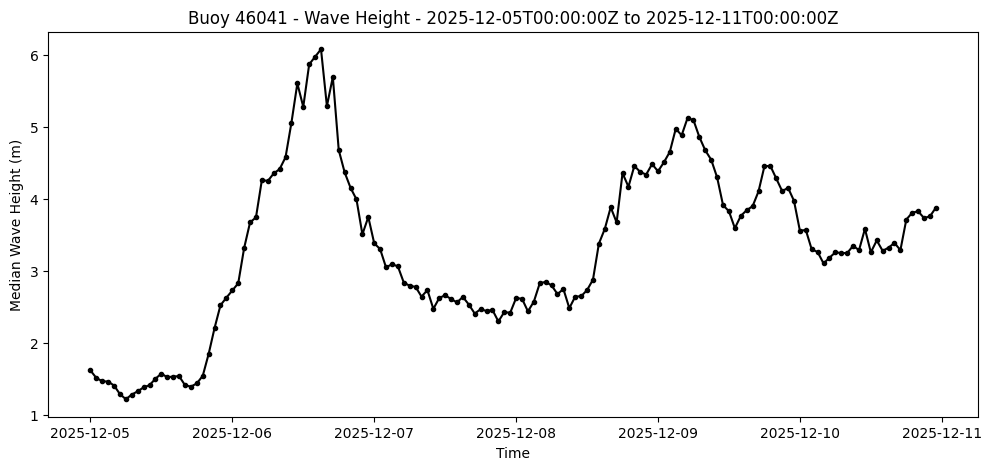

In [6]:
#plot wave heights as a function of time
plt.figure(figsize=(12,5))
plt.plot(buoytime_hourly, sigwaveheight_hourly, marker='.', linestyle='solid', color='black')
plt.xlabel("Time")
plt.ylabel("Median Wave Height (m)")
plt.title(f"Buoy {station} - Wave Height - {start} to {end}")
plt.show()

In [7]:
# remove NaNs with mask from both arrays and plot that way
# mask = ~np.isnan(wave_height)
# plt.figure(figsize=(12,5))
# plt.plot(np.array(time)[mask], np.array(wave_height)[mask],
#          linestyle='solid', linewidth=1.5, color='black')
# plt.xlabel("Time")
# plt.ylabel("Wave Height (m)")
# plt.title(f"Buoy {station} - Wave Height")
# plt.show()

In [8]:
#plot wind speeds as a function of time
# plt.figure(figsize=(12,5))
# plt.plot(time, wind_speed,linestyle='solid', linewidth=1.5, color='black')
# plt.xlabel("Time")
# plt.ylabel("Median Wind Speeds (m/s)")
# plt.title(f"Buoy {station} - Wind Speed")
# plt.show()

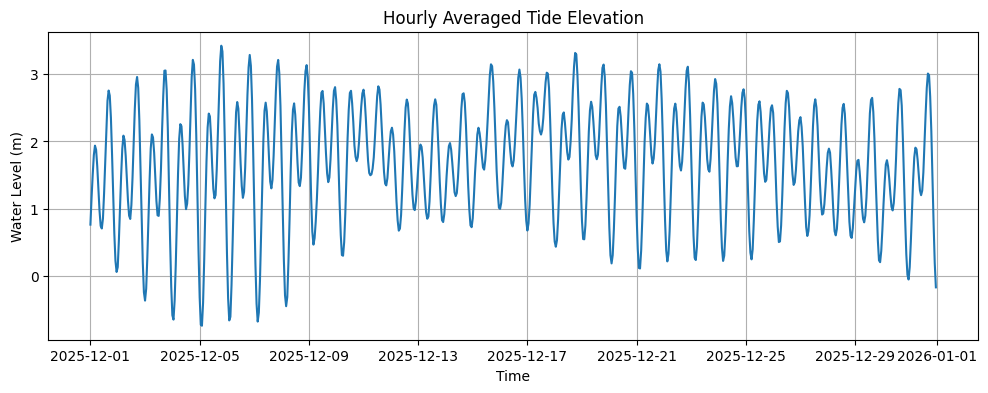

In [9]:
#code to upload tide and inland wind speeds from csv files

#tides found here https://tidesandcurrents.noaa.gov/waterlevels.html?id=9442396&units=metric&bdate=20251201&edate=20251231&timezone=GMT&datum=MLLW&interval=6&action=data
#wind speed downloaded here https://tidesandcurrents.noaa.gov/met.html?bdate=20251201&edate=20251231&units=metric&timezone=GMT&id=9442396&interval=h&action=data
#downloaded tide values against MLLW
#downlaoded wind speeds every hour
#La Push, Quillayute River, WA - Station ID: 9442396 
#Santa Barbara, CA - Station ID: 9411340

#read in the csv files
#forks washington
tide_data = pd.read_csv('CO-OPS_9442396_wl.csv')
wind_inland = pd.read_csv('CO-OPS_9442396_met6.csv')
#santa barbara
#tide_data = pd.read_csv('CO-OPS_9411340_wl.csv')
#wind_inland = pd.read_csv('CO-OPS_9411340_met.csv')

#start with tide file
#turn time into datetime format
time_td = pd.to_datetime(tide_data['Date'] + 'T' + tide_data['Time (GMT)'])
#put water level and time into one array
#if ‘coerce’, then invalid parsing will be set as NaN
tide_data['DateTime'] = time_td
tide_data['Verified (m)'] = pd.to_numeric(tide_data['Verified (m)'], errors='coerce')
tide_data = tide_data.set_index('DateTime')

#go from every 6 minutes to ever hour, take median
tide_hourly = tide_data['Verified (m)'].resample('1h').median()
#tide_hourly = tide_data['Verified (m)'].resample('1h').quantile(0.95)

#turn pandas list into numpy array
time_hourly = tide_hourly.index.to_numpy(dtype='datetime64[h]')
water_level_hourly = tide_hourly.to_numpy()

plt.figure(figsize=(12, 4))
plt.plot(time_hourly, water_level_hourly)
plt.xlabel('Time')
plt.ylabel('Water Level (m)')
plt.title('Hourly Averaged Tide Elevation')
plt.grid(True)
plt.show()


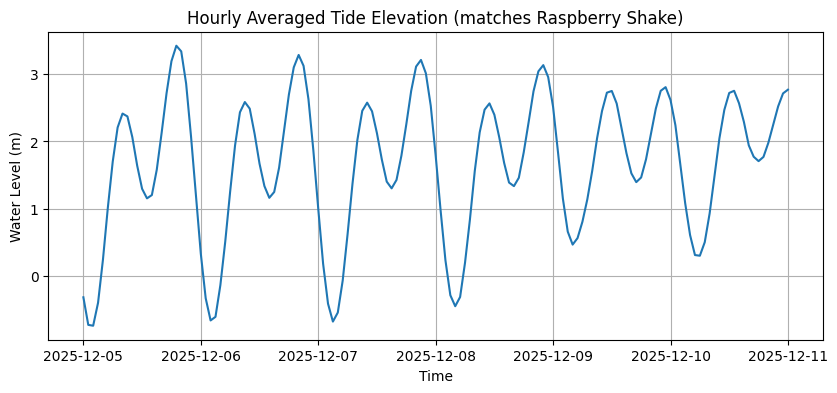

In [10]:
#to subset the data by certain days, using pandas
#tide_subset = tide_hourly['2025-12-05':'2025-12-11']

#numpy forks wa
start = np.datetime64('2025-12-05')
end   = np.datetime64('2025-12-11')

#santa barbara
#start = np.datetime64('2025-12-21')
#end   = np.datetime64('2025-12-27')

mask = (time_hourly >= start) & (time_hourly <= end)

time_subset = time_hourly[mask]
water_subset = water_level_hourly[mask]

#plot subset
plt.figure(figsize=(10, 4))
plt.plot(time_subset, water_subset)
#plt.plot(tide_subset.index, tide_subset.values)
plt.xlabel('Time')
plt.ylabel('Water Level (m)')
plt.title('Hourly Averaged Tide Elevation (matches Raspberry Shake)')
plt.grid(True)
plt.show()

#water_level = tide_data['Verified (m)']

#plt.plot(time_td, water_level)
#plt.xlabel("Time")
#plt.ylabel("Tide Water Level (m)")
#plt.title("Tide Gauge")
#plt.show()

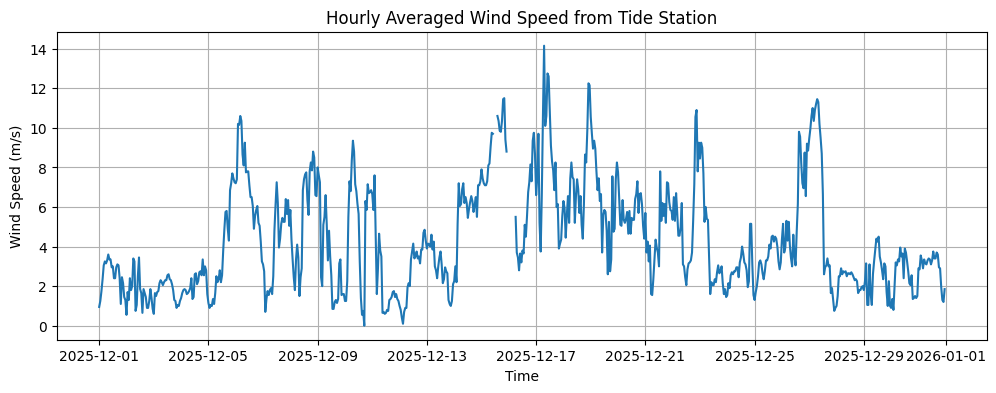

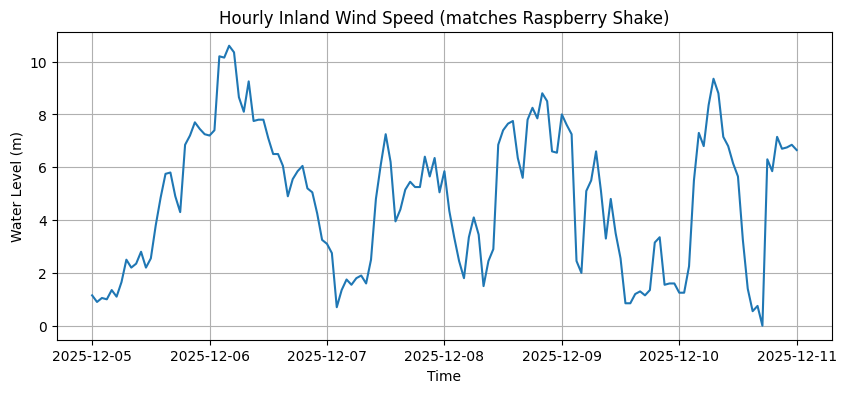

In [11]:
time_wd = wind_inland['Date'] + 'T' + wind_inland['Time (GMT)']
time_wd = pd.to_datetime(time_wd)

wind_inland['DateTime'] = time_wd
wind_inland['Wind Speed (m/s)'] = pd.to_numeric(wind_inland['Wind Speed (m/s)'], errors='coerce')
wind_inland = wind_inland.set_index('DateTime')

#go from every 6 minutes to ever hour, take average
windin_hourly = wind_inland['Wind Speed (m/s)'].resample('1h').median()
#windin_hourly = wind_inland['Wind Speed (m/s)'].resample('1h').quantile(0.95)

#turn pandas list into numpy array
timew_hourly = windin_hourly.index.to_numpy(dtype='datetime64[h]')
inland_wind_hourly = windin_hourly.to_numpy()

plt.figure(figsize=(12, 4))
plt.plot(timew_hourly, inland_wind_hourly)
plt.xlabel('Time')
plt.ylabel('Wind Speed (m/s)')
plt.title('Hourly Averaged Wind Speed from Tide Station')
plt.grid(True)
plt.show()

maskwind = (timew_hourly >= start) & (timew_hourly <= end)

timewind_subset = timew_hourly[maskwind]
wind_subset = inland_wind_hourly[maskwind]

#plot subset
plt.figure(figsize=(10, 4))
plt.plot(timewind_subset, wind_subset)
#plt.plot(tide_subset.index, tide_subset.values)
plt.xlabel('Time')
plt.ylabel('Water Level (m)')
plt.title('Hourly Inland Wind Speed (matches Raspberry Shake)')
plt.grid(True)
plt.show()


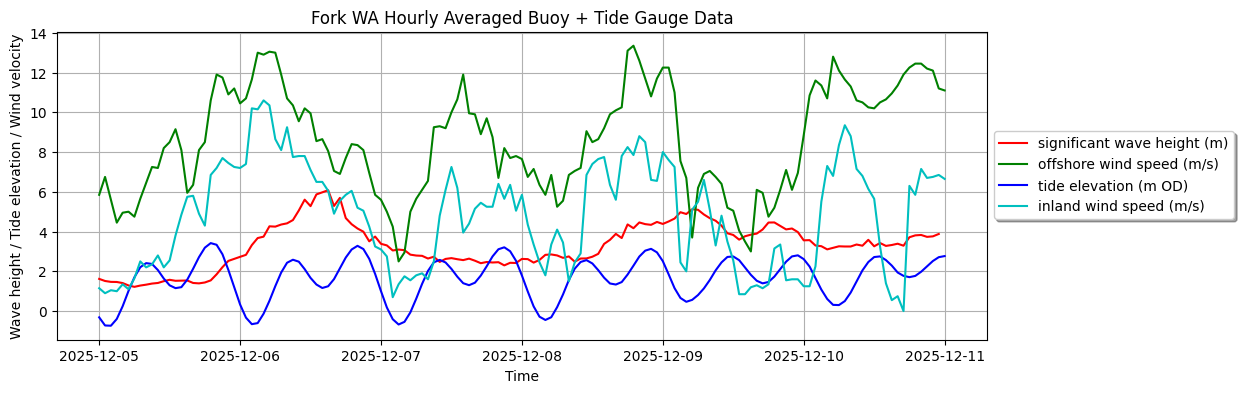

In [12]:
#plot all the datasets together

fig, ax = plt.subplots(figsize=(12, 4)) 
plt.plot(buoytime_hourly, sigwaveheight_hourly, color='r', label='significant wave height (m)')
plt.plot(buoytime_hourly, offshorewind_hourly, color='g', label='offshore wind speed (m/s)')
plt.plot(time_subset, water_subset, color='b', label='tide elevation (m OD)')
plt.plot(timewind_subset, wind_subset, color='c', label='inland wind speed (m/s)')
plt.xlabel('Time')
plt.ylabel('Wave height / Tide elevation / Wind velocity')
plt.title('Fork WA Hourly Averaged Buoy + Tide Gauge Data')
plt.grid(True)
#plt.legend(loc='upper left')
ax.legend(loc='upper left', bbox_to_anchor=(1, 0.7), ncol=1, fancybox=True, shadow=True)
#plt.savefig('buoy_tide1.png')
plt.show()

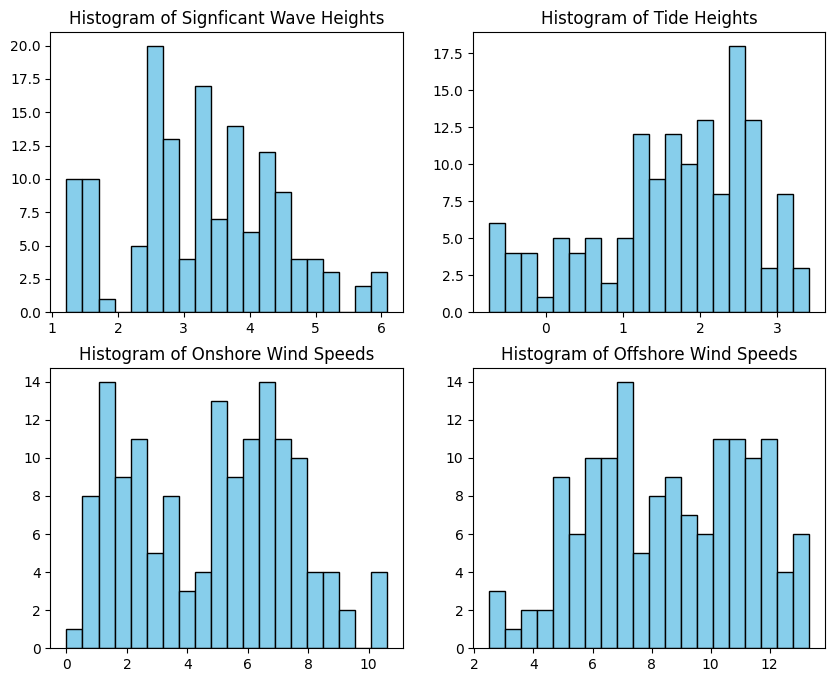

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes[0,0].hist(sigwaveheight_hourly, bins=20, color='skyblue', edgecolor='black')
axes[0, 0].set_title("Histogram of Signficant Wave Heights")
axes[0,1].hist(water_subset, bins=20, color='skyblue', edgecolor='black')
axes[0, 1].set_title("Histogram of Tide Heights")
axes[1,0].hist(wind_subset, bins=20, color='skyblue', edgecolor='black')
axes[1, 0].set_title("Histogram of Onshore Wind Speeds")
axes[1,1].hist(offshorewind_hourly, bins=20, color='skyblue', edgecolor='black')
axes[1, 1].set_title("Histogram of Offshore Wind Speeds")
plt.show()

# plt.hist(offshorewind_hourly, bins=20, color='skyblue', edgecolor='black')
# plt.title("Histogram of Offshore Wind Speeds")
# plt.xlabel("Value")
# plt.ylabel("Frequency")
# plt.show()

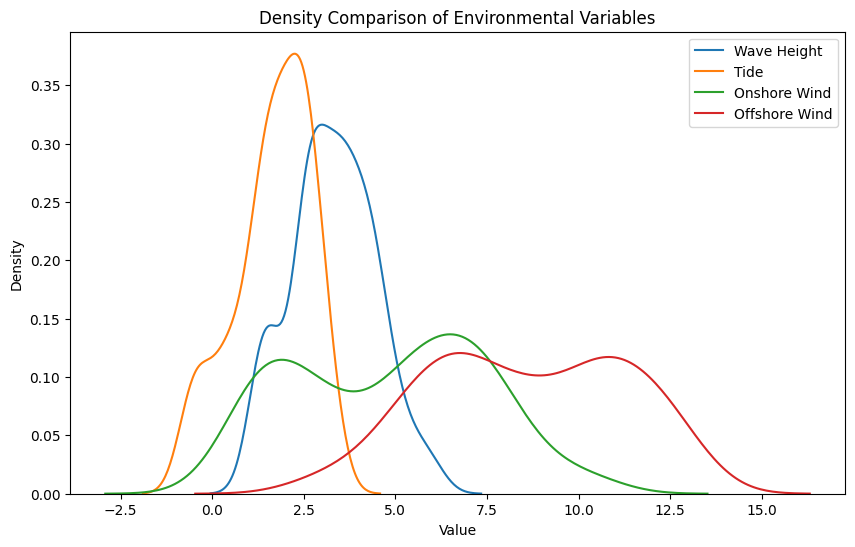

In [ ]:

plt.figure(figsize=(10,6))

sns.kdeplot(sigwaveheight_hourly, bw_method="scott", label="Wave Height")
sns.kdeplot(water_subset, bw_method="scott", label="Tide")
sns.kdeplot(wind_subset, bw_method="scott", label="Onshore Wind")
sns.kdeplot(offshorewind_hourly, bw_method="scott", label="Offshore Wind")

plt.legend()
plt.xlabel("Value")
plt.ylabel("Density")
plt.title("Density Comparison of Environmental Variables")
plt.show()

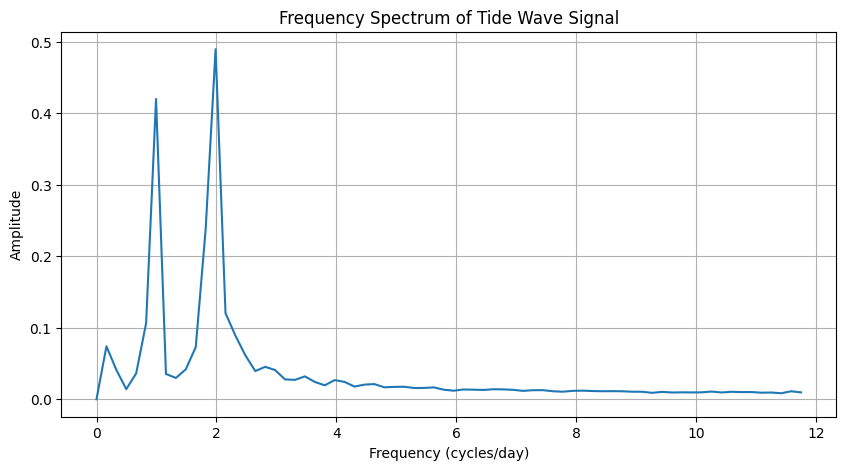

In [15]:
trace = Trace(data=water_subset)
signal = trace - np.mean(trace)
#signal = water_subset - np.mean(water_subset)

N = len(signal)

# Compute FFT
fft_vals = np.fft.rfft(signal)
# Get frequencies (cycles per day if this is hourly data)
freqs = np.fft.rfftfreq(N, d=1/24)
# Magnitude
magnitude = np.abs(fft_vals) / N

# Plot FFT spectrum
# Plotting first half (positive frequencies)
plt.figure(figsize=(10,5))
plt.plot(freqs[:N//2], magnitude[:N//2])
plt.title("Frequency Spectrum of Tide Wave Signal")
plt.xlabel("Frequency (cycles/day)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

#1 cycle/day →  24-hour tide
#2 cycles/day → 12-hour tide
#4 cycles/day → 6-hour tide


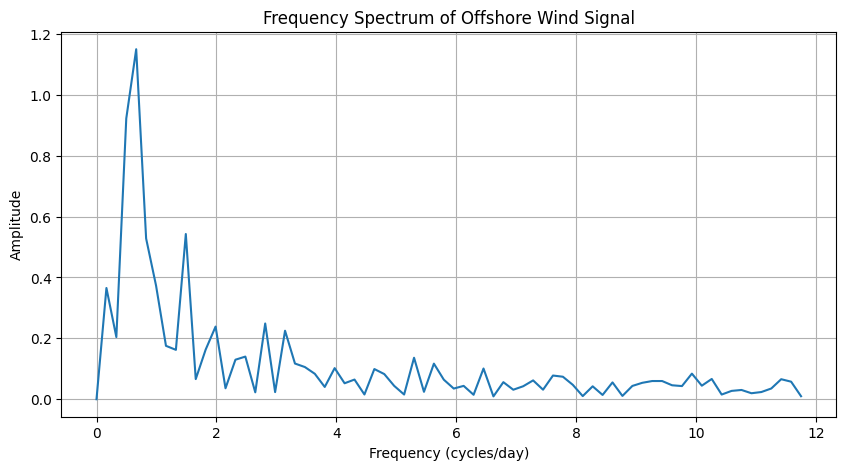

In [16]:
trace = Trace(data=offshorewind_hourly)
signal = trace - np.mean(trace)
N = len(signal)

# Compute FFT
fft_vals = np.fft.rfft(signal)
# Get frequencies (cycles per day if this is hourly data)
freqs = np.fft.rfftfreq(N, d=1/24)
# Magnitude
magnitude = np.abs(fft_vals) / N

# Plot FFT spectrum
# Plotting first half (positive frequencies)
plt.figure(figsize=(10,5))
plt.plot(freqs[:N//2], magnitude[:N//2])
plt.title("Frequency Spectrum of Offshore Wind Signal")
plt.xlabel("Frequency (cycles/day)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()